In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import root
from scipy.optimize import newton
from scipy.optimize import fsolve

In [2]:
def drift(length):
    drift_matrix = np.array([[1., length, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., length, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., 0., 1.]])
    return drift_matrix

def quad(length, gauss, Brho, diameter):
    
    h = np.abs(gauss/Brho)
    c11 = np.cos(length*np.sqrt(10*h/diameter))
    c12 = np.sin(length*np.sqrt(10*h/diameter))/np.sqrt(10*h/diameter)
    c21 = -np.sin(length*np.sqrt(10*h/diameter))*np.sqrt(10*h/diameter)
    d11 = np.cosh(length*np.sqrt(10*h/diameter))
    d12 = np.sinh(length*np.sqrt(10*h/diameter))/np.sqrt(10*h/diameter)
    d21 = np.sinh(length*np.sqrt(10*h/diameter))*np.sqrt(10*h/diameter)
    
    quad_matrix = drift(length)
    
    
    if gauss > 0:
        quad_matrix = np.array([[c11, c12, 0., 0., 0., 0.],
                                [c21, c11, 0., 0., 0., 0.],
                                [0., 0., d11, d12, 0., 0.],
                                [0., 0., d21, d11, 0., 0.],
                                [0., 0., 0., 0., 1., 0.],
                                [0., 0., 0., 0., 0., 1.]])
    if gauss < 0:
        quad_matrix = np.array([[d11, d12, 0., 0., 0., 0.],
                                [d21, d11, 0., 0., 0., 0.],
                                [0., 0., c11, c12, 0., 0.],
                                [0., 0., c21, c11, 0., 0.],
                                [0., 0., 0., 0., 1., 0.],
                                [0., 0., 0., 0., 0., 1.]])
    return quad_matrix

Transport workflow:

Initialize and name trajectory.

set the kV.

define rays for plotting and optimization

add elements

effective length correction not implemented yet. Only works if there is a drift between each quad.

calculate rays and maps for optimization

optimize

calculate rays and maps for plotting, plot

In [90]:
class Transport:
    def __init__(self):
        
        self.ray_set = False # to raise exception of you try to plot or crunch without a ray
        self.rays = {} # to store initial ray values
        self.layer=0 #order of elements     
        self.elements={} #store element info to adjust elements
        self.column = [] #column configuration for calculations
        self.map = np.identity(6) #total map
        self.map_layers = [] #store the map state at each layer
        
    def set_kV(self, kV=100):
        self.kV = kV
        self.rel_kV = kV*(1+kV/1022)
        self.mv = np.sqrt(2*511*self.rel_kV)*.000001 #(GeV/c)
        self.Brho = 3.3356*self.mv 
        
    def set_ray(self, label, x=0, x_angle=0, y=0, y_angle=0):
        self.ray_set = True
        ray = np.array([x, x_angle, y, y_angle, 0, 0])
        ray_dict={}
        ray_dict['init'] = ray
        self.rays[label] = ray_dict
        
    def add_drift(self, label, length):
        layer = self.layer
        self.layer += 1
        el_dict = {}
        el_dict['layer'] = layer
        el_dict['type'] = 'drift'
        el_dict['length'] = length
        self.elements[label] = el_dict
            
    def add_quad(self, label, length, gauss, radius, slices=8):
        layer = self.layer
        self.layer += 1
        el_dict = {}
        el_dict['layer'] = layer
        el_dict['type'] = 'quad'
        el_dict['length'] = length
        el_dict['gauss'] = gauss
        el_dict['radius'] = radius
        el_dict['slices'] = slices
        self.elements[label] = el_dict
        
    def eff_length(self):
        return
    
    def crunch(self):
        
        self.column = [] #column configuration for calculations
        self.map = np.identity(6).copy() #total map
        self.map_layers = [] #store the map state at each layer
        self.axial_width_x = []
        self.axial_width_y = []
        self.axial_ang_x = []
        self.axial_ang_y = []
        self.field_width_x = []
        self.field_width_y = []
        self.field_ang_x = []
        self.field_ang_y = []        
        
        for key in self.elements:
            el = self.elements[key]
            if el['type']=='drift':
                drift_matrix = drift(el['length'])
                self.map = drift_matrix@self.map
                self.map_layers.append(self.map)
                self.column.append([el['length'], drift_matrix])
            if el['type'] == 'quad':      
                quad_matrix = quad(el['length'], el['gauss'], self.Brho, 2*el['radius'])
                self.map = quad_matrix@self.map
                self.map_layers.append(self.map)
                self.column.append([el['length'], quad_matrix])           
            
            xx = self.map[0,0]
            yy = self.map[2,2]
            xa = self.map[0,1]
            xb = self.map[0,3]
            
            self.axial_width_x.append(np.sqrt(xa**2+xb**2)*xa/np.abs(xa))
            
            
        
        self.axial_width_x = .0001*np.array(self.axial_width_x)
        
        if self.ray_set:
            for key in self.rays:

                ray = self.rays[key]['init'].copy()

                z = 0

                ray_x = []
                ray_y = []
                ray_z = []

                ray_x.append(ray[0])
                ray_y.append(ray[2])
                ray_z.append(z)

                for el in self.column:

                    length = el[0]
                    matrix = el[1]

                    z += length
                    ray = matrix@ray

                    ray_x.append(ray[0])
                    ray_y.append(ray[2])
                    ray_z.append(z)

                self.rays[key]['x'] = ray_x
                self.rays[key]['y'] = ray_y
                self.rays[key]['z'] = ray_z
        else:
            print('no rays have been set')
            
    def ray_func(self, in_val, in_label, in_param, out_label, out_ray, out_axis):
        self.elements[in_label][in_param] = in_val
        self.crunch()
        layer = self.elements[out_label]['layer']
        return self.rays[out_ray][out_axis][layer]
    
    def ray_goal(self, goal, in_label, in_param, out_label, out_ray, out_axis): 
        def out(x): #just to make things more compact
            put = self.ray_func(x, in_label=in_label, 
                                     in_param=in_param, 
                                     out_label=out_label, 
                                     out_ray=out_ray,
                                     out_axis=out_axis)
            return put-goal
        x0 = self.elements[in_label][in_param]
        root = newton(out, x0)
        self.elements[in_label][in_param] = root

        
        
    def map_func(self, in_vec, in_labels, in_params, out_label, out_mxs, out_mys):
        for idx, in_val in enumerate(in_vec):
            self.elements[in_labels[idx]][in_params[idx]] = in_val
        self.crunch()
        layer = self.elements[out_label]['layer']
        map_layer=self.map_layers[layer]
        return [map_layer[out_mxs[0], out_mys[0]], map_layer[out_mxs[1], out_mys[1]],
                map_layer[0, 0] - map_layer[2, 2]]
        
    def map_goal(self,in_label, in_param, out_label, out_ray, out_axis): 
        def out(x): #just to make things more compact
            put = self.ray_func(x, in_label=in_label, 
                                     in_param=in_param, 
                                     out_label=out_label, 
                                     out_ray=out_ray,
                                     out_axis=out_axis)
            return put-goal
        x0 = self.elements[in_label][in_param]
        root = newton(out, x0)
        self.elements[in_label][in_param] = root
        
    def plot(self):
        
        if not self.ray_set:
            
            print('no rays have been set')
            
        #make column list:
        
        self.plot_column = []
        
        for key in self.elements:
            el = self.elements[key]
            if el['type']=='drift':
                drift_matrix = drift(el['length'])
                self.plot_column.append([el['length'], drift_matrix])
            if el['type'] == 'quad':
                for i in range(el['slices']):           
                    quad_matrix = quad(el['length']/el['slices'], el['gauss'], self.Brho, 2*el['radius'])
                    self.plot_column.append([el['length']/el['slices'], quad_matrix])
                
        
        
        for key in self.rays:
            
            ray = self.rays[key]['init'].copy()
            
            z = 0
            
            ray_x = []
            ray_y = []
            ray_z = []

            ray_x.append(ray[0])
            ray_y.append(ray[2])
            ray_z.append(z)
            
            for el in self.plot_column:
                
                length = el[0]
                matrix = el[1]
                
                z += length
                ray = matrix@ray
                
                ray_x.append(ray[0])
                ray_y.append(ray[2])
                ray_z.append(z)
                

            plt.figure(figsize=[12,3])
            plt.title(key)
            plt.plot(ray_z, ray_x, label='x')
            plt.plot(ray_z, ray_y, label='y')
            plt.legend()
        
        

        
    

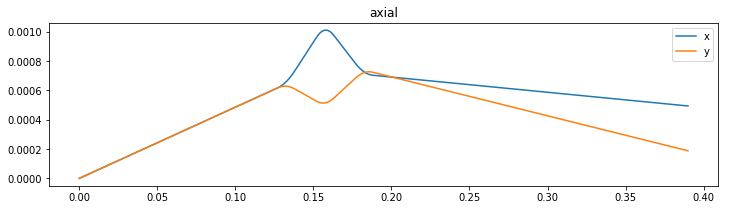

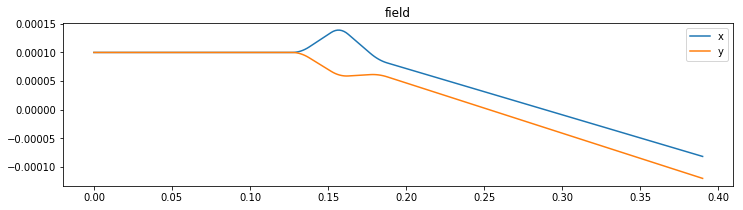

In [91]:
traj1=Transport()

traj1.set_kV(100)

traj1.set_ray('axial', x_angle=1/0.6/342.9, y_angle=1/0.6/342.9)

traj1.set_ray('field', x=.0001, y=0.0001)

traj1.add_drift('drift1', length=.127)

traj1.add_quad('quad1', length=.011, gauss=-.23, radius=.65)

traj1.add_drift('drift2', length=.014)

traj1.add_quad('quad2', length=.011, gauss=.40, radius=.65)

traj1.add_drift('drift3', length=.014)

traj1.add_quad('quad3', length=.011, gauss=-.23, radius=.65)

traj1.add_drift('drift4', length=.2)
traj1.add_drift('drift5', length=.002)

# traj1.add_quad('quad4', length=.011, gauss=-.22, radius=.65)

# traj1.add_drift('drift5', length=.014)

# traj1.add_quad('quad5', length=.011, gauss=.4, radius=.65)

# traj1.add_drift('drift6', length=.014)

# traj1.add_quad('quad6', length=.011, gauss=-.22, radius=.65)

# traj1.add_drift('drift7', length=.2)

traj1.plot()

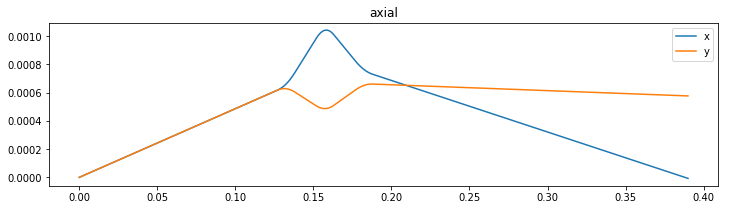

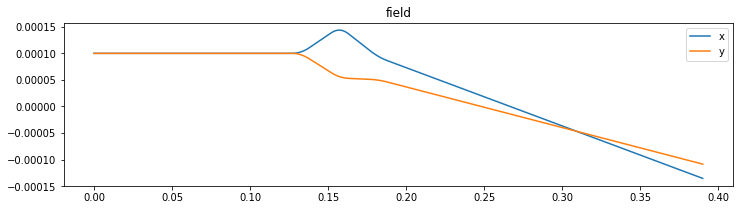

In [60]:
# traj1.ray_goal(goal=0.0075,
#                in_label='quad1', 
#                in_param='gauss', 
#                out_label='drift4', 
#                out_ray='axial', 
#                out_axis='y')

traj1.ray_goal(goal=0.00075,
               in_label='quad1', 
               in_param='gauss', 
               out_label='drift4', 
               out_ray='axial', 
               out_axis='x')

traj1.ray_goal(goal=0,
               in_label='quad3', 
               in_param='gauss', 
               out_label='drift5', 
               out_ray='axial', 
               out_axis='x')

# traj1.ray_goal(goal=0.00075,
#                in_label='quad2', 
#                in_param='gauss', 
#                out_label='drift4', 
#                out_ray='axial', 
#                out_axis='y')

# traj1.ray_goal(goal=0,
#                in_label='quad3', 
#                in_param='gauss', 
#                out_label='drift5', 
#                out_ray='axial', 
#                out_axis='y')

traj1.plot()

In [61]:
#     def ray_func(self, in_label, in_param, in_val, out_ray, out_axis):
#         self.elements[in_label][in_param] = in_val
#         self.crunch()
        
#         layer = self.elements[out_label]['layer']
#         return self.rays[out_ray][out_axis][layer]

traj1.ray_func(-0.41,in_label='quad2', 
               in_param='gauss',  
               out_label='quad3', 
               out_ray='axial', 
               out_axis='y')

5.728999549134807e-05

In [62]:
traj1.elements['quad1']['gauss']=-.22
traj1.crunch()
traj1.rays['axial']['x']

[0.0,
 0.000617283950617284,
 0.0007298320246604874,
 0.0009526330619928415,
 0.0013051976646759331,
 0.0020052329397405493,
 0.0027106437930139687,
 0.01866086350582908,
 0.01882036570295723]

In [63]:
traj1.elements['quad1']['gauss']=-.22
traj1.crunch()
traj1.axial_width_x

array([1.27000000e-05, 1.50155641e-05, 1.95994726e-05, 2.68531368e-05,
       4.12556625e-05, 5.57687854e-05, 3.83928606e-04, 3.87210204e-04])

In [64]:
traj1.elements['quad1']['gauss']=-.23

traj1.crunch()

print(traj1.elements['quad1']['gauss'])

-0.23


In [65]:
# def map_func(self, in_vec, in_labels, in_params, out_label, out_mx, out_my):
#     for idx, in_val in enumerate(in_vec):
#         self.elements[in_labels[idx]][in_params[idx]] = in_val
#     self.crunch()
#     layer = self.elements[out_label]['layer']
#     map_layer=self.map_layers[layer]
#     return map_layer[out_mx, out_my]

In [78]:
traj1.map_func([.4, .22], ['quad2', 'quad3'], ['gauss', 'gauss'], 'drift5', [0,2], [1,3])

# traj1.plot()

[-0.9318160848490035, 1.1114498333981655]

In [94]:
fsolve(traj1.map_func, [-.22, .4,  -0.22], 
       (['quad1', 'quad2', 'quad3'], ['gauss', 'gauss', 'gauss'], 'drift5', [0,2], [1,3]))

array([-0.26018197,  0.44158149, -0.24503401])

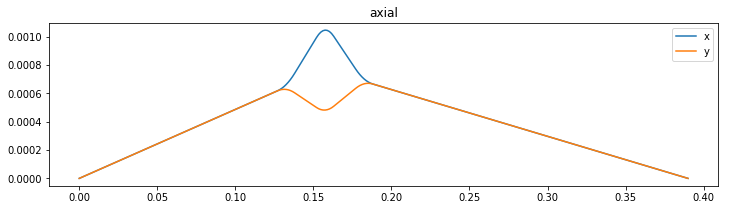

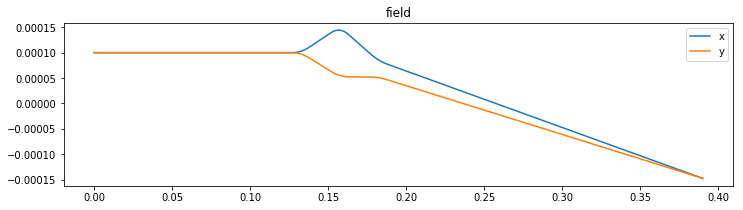

In [95]:
traj1.map_func([-0.26018197,  0.44158149, -0.24503401], ['quad1', 'quad2', 'quad3'], ['gauss', 'gauss', 'gauss'], 'drift5', [0,2], [1,3])

traj1.plot()